In [2]:
# -*- coding: UTF-8 -*-
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm
from scipy.fftpack import fft
from matplotlib.pylab import mpl
import csv
import array
import sqlite3
import pprint
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker, cm


%matplotlib qt
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.unicode_minus'] = False  #显示负号

In [13]:
os.chdir(r'E:\data\vallen\Ni-tension test-pure-1-0.01-AE-20201030')
path_pri = r'Ni-tension test-pure-1-0.01-AE-20201030.pridb'
path_tra = r'Ni-tension test-pure-1-0.01-AE-20201030.tradb'
# 316L-1.5-z3-AE-3 sensor-20200530
# Ni-tension test-electrolysis-1-0.01-AE-20201031
# Ni-tension test-pure-1-0.01-AE-20201030
# 2020.11.10-PM-self

conn_tra = sqlite3.connect(path_tra)
conn_pri = sqlite3.connect(path_pri)
result_tra = conn_tra.execute("Select Time, Chan, Thr, SampleRate, Samples, TR_mV, Data, TRAI FROM view_tr_data")
result_pri = conn_pri.execute("Select SetID, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts, TRAI FROM view_ae_data")

### Convert

In [4]:
def sqlite_read(path):
    """
    python读取sqlite数据库文件
    """
    mydb = sqlite3.connect(path)                # 链接数据库
    mydb.text_factory = lambda x: str(x, 'gbk', 'ignore')
    cur = mydb.cursor()                         # 创建游标cur来执行SQL语句

    # 获取表名
    cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
    Tables = cur.fetchall()                     # Tables 为元组列表
#     print(Tables)

    # 获取表结构的所有信息
    cur.execute("SELECT * FROM {}".format(Tables[3][0]))
    res = cur.fetchall()
#     pprint.pprint(cur.fetchall()[-1][1])
    return int(res[-2][1]), int(res[-1][1])

In [14]:
data_tra, data_pri, chan_2, chan_3, chan_4 = [], [], [], [], []
N_pri, N_tra = sqlite_read(path_pri)
for _ in tqdm(range(N_tra),ncols=80):
    i = result_tra.fetchone()
    data_tra.append(i)
for _ in tqdm(range(N_pri),ncols=80):
    i = result_pri.fetchone()
    if i[-2] is not None and i[-2] > 2:
        data_pri.append(i)
        if i[2] == 2:
            chan_2.append(i)
        elif i[2] == 3:
            chan_3.append(i)
        elif i[2] == 4:
            chan_4.append(i)

data_tra = sorted(data_tra, key=lambda x: x[-1])
data_pri = np.array(data_pri)
chan_2 = np.array(chan_2)
chan_3 = np.array(chan_3)
chan_4 = np.array(chan_4)

100%|█████████████████████████████| 5354736/5354736 [00:25<00:00, 209002.04it/s]


### Plot format

In [6]:
color_1 = [255/255, 0/255, 102/255] # red
color_2 = [0/255, 136/255, 204/255] # blue

def formatnum(x, pos):
    return '$10^{}$'.format(int(x))

def plot_norm(ax, xlabel, ylabel, title='', grid=False, formatter_x=False, formatter_y=False, 
              x_lim=[], y_lim=[], legend=True, legend_loc='upper left'):
    formatter1 = FuncFormatter(formatnum)
    if formatter_x:
        ax.xaxis.set_major_formatter(formatter1)
    if formatter_y:
        ax.yaxis.set_major_formatter(formatter1)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)

    # 设置坐标刻度值的大小以及刻度值的字体
    plt.tick_params(labelsize=12)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('DejaVu Sans') for label in labels]

    font_legend = {'family':'DejaVu Sans','weight':'normal','size':14}
    font_label = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 15}
    font_title = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 18}
    
    if x_lim:
        plt.xlim(x_lim[0], x_lim[1])
    if y_lim:
        plt.ylim(y_lim[0], y_lim[1])
    if legend:
        plt.legend(loc=legend_loc, prop = font_legend)
    if grid:
        ax.grid(ls='-.')
    ax.set_xlabel(xlabel, font_label)
    ax.set_ylabel(ylabel, font_label)
    ax.set_title(title, font_title)
    plt.tight_layout()

### Features extract

In [7]:
chan_2.shape, chan_3.shape, chan_4.shape

((515, 11), (578, 11), (189, 11))

In [8]:
# SetID, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts, TRAI
Time = chan_2[:, 1]
Amp = chan_2[:, 4]
RiseT = chan_2[:, 5]
Dur = chan_2[:, 6]
Eny = chan_2[:, 7]
RMS = chan_2[:, 8]
Counts = chan_2[:, 9]

### Energy-Time Curve

In [113]:
df_1 = pd.DataFrame({'time':Time[cls_1_KKM], 'energy':Eny[cls_1_KKM]})
df_2 = pd.DataFrame({'time':Time[cls_2_KKM], 'energy':Eny[cls_2_KKM]})
df_1.to_csv('E-T_pure_pop1.csv')
df_2.to_csv('E-T_pure_pop2.csv')

In [ ]:
fig = plt.figure(figsize=[6, 4.5])
ax = plt.subplot()
ax.scatter(Time, np.log10(Eny))
ax.set_xticks(np.linspace(0, 40000, 9))
ax.set_yticks([-1, 0, 1, 2, 3])
plot_norm(ax, 'Time(s)', 'Energy(aJ)', legend=False, formatter_y=True)

###  Validate features

In [9]:
# Time, Amp, RiseTime, Dur, Eny, Counts, TRAI
def validation(k):
    i = data_tra[k]
    sig = np.multiply(array.array('h', bytes(i[-2])), i[-3] * 1000)
    time = np.linspace(i[0], i[0] + pow(i[-5], -1) * (i[-4] - 1), i[-4])

    thr = i[2]
    valid_wave_idx = np.where(abs(sig) >= thr)[0]
    valid_time = time[valid_wave_idx[0]:(valid_wave_idx[-1] + 1)]
    start = time[valid_wave_idx[0]]
    end = time[valid_wave_idx[-1]]
    duration = (end - start) * pow(10, 6)
    max_idx = np.argmax(abs(sig))
    amplitude = max(abs(sig))
    rise_time = (time[max_idx] - start) * pow(10, 6)
    valid_data = sig[valid_wave_idx[0]:(valid_wave_idx[-1] + 1)]
    energy = np.sum(np.multiply(pow(valid_data, 2), pow(10, 6) / i[3]))
    RMS = math.sqrt(energy / duration)
    count, idx = 0, 1
    N = len(valid_data)
    for idx in range(1, N):
        if valid_data[idx - 1] >= thr > valid_data[idx]:
            count += 1
    # while idx < N:
    #     if min(valid_data[idx - 1], valid_data[idx]) <= thr < max((valid_data[idx - 1], valid_data[idx])):
    #         count += 1
    #         idx += 2
    #         continue
    #     idx += 1
    print(i[0], amplitude, rise_time, duration, energy / pow(10, 4), count, i[-1])

### Energy-Amplitude with different channel

In [ ]:
fig = plt.figure(figsize=[6, 4.5])
ax = plt.subplot()

ax.scatter(np.log10(chan_2[:, 4]), np.log10(chan_2[:, 7]), s=35, c=color_2, label='Original data')
# ax.scatter(np.log10(Amp)[cls_select], np.log10(Eny)[cls_select], s=35, c='y', label='Random Select')

# # ax.scatter(S_[cls_1_KKM, 0], S_[cls_1_KKM, 1], s=15, c=color_1)
# # ax.scatter(S_[cls_2_KKM, 0], S_[cls_2_KKM, 1], s=15, c=color_2)
# ax.scatter(np.log10(Amp)[cls_1_KKM], np.log10(Eny)[cls_1_KKM], s=25, c=color_1)
# ax.scatter(np.log10(Amp)[cls_2_KKM], np.log10(Eny)[cls_2_KKM], s=25, c=color_2)

ax.set_xticks([1.3, 2, 3], ('', 2, 3))
ax.set_yticks([-1.5, -1, 0, 1, 2, 3], ('', -1, 0, 1, 2, 3))

plot_norm(ax, 'Component 1', 'Component 2', 'Chan 2')

In [20]:
%matplotlib notebook

In [19]:
fig = plt.figure(figsize=[6, 4.5])
ax = plt.subplot()

# plt.scatter(np.log10(chan_2[:, 4]), np.log10(chan_2[:, 7]), s=15, c=color_2)

# plt.scatter(S_[cls_1_KKM, 0], S_[cls_1_KKM, 1], s=15, c=color_1)
# plt.scatter(S_[cls_2_KKM, 0], S_[cls_2_KKM, 1], s=15, c=color_2)
# # # plt.scatter(S_[:, 0], S_[:, 1], s=15, c=color_2)
ax.scatter(np.log10(Dur)[cls_2_KKM], np.log10(Eny)[cls_2_KKM], s=25, c=color_2, label='Class 2')
ax.scatter(np.log10(Dur)[cls_1_KKM], np.log10(Eny)[cls_1_KKM], s=25, c=color_1, label='Class 1')
ax.scatter(np.log10(Dur)[cls_1_KKM][idx_select_1], np.log10(Eny)[cls_1_KKM][idx_select_1], s=25, c='y', label='Random selection')
ax.scatter(np.log10(Dur)[cls_2_KKM][idx_select_2], np.log10(Eny)[cls_2_KKM][idx_select_2], s=25, c='purple', label='Random selection')

plot_norm(ax, 'Duration(μs)', 'Energy(aJ)', 'Chan 2')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


### Find Wave

In [18]:
# 1.263, 1.395, 1.538, 1.728, 1.832, 2.233, 2.450, 2.573, 2.702, 3.079
idx_1 = [5, 70, 3, 9, 0, 20, 136, 42, 54, 108]
TRAI_1 = [735, 3218, 593, 1138, 323, 2001, 6585, 2614, 2832, 4619]

# 1.365, 1.495, 1.773, 1.839, 1.95, 2.258, 2.390, 2.507, 2.680, 2.875
idx_2 = [0, 172, 1, 3, 5, 112, 7, 144, 2, 137]
TRAI_2 = [323, 9776, 383, 593, 735, 4694, 909, 7445, 405, 6695]

In [17]:
# 0.115, 0.275, 0.297, 0.601, 1.024
idx_select_2 = [50, 148, 51, 252, 10]
TRAI_select_2 = [3067, 11644, 3079, 28583, 1501]

# 0.303, 0.409, 0.534, 0.759, 1.026
idx_select_1 = [13, 75, 79, 72, 71]
TRAI_select_1 = [2949, 14166, 14815, 14140, 14090]

In [132]:
for i in np.where((np.log10(Dur)[cls_2_KKM] > 2.6) & (np.log10(Dur)[cls_2_KKM] < 2.8) & (np.log10(Eny)[cls_2_KKM] < 1.25))[0]:
    # Idx, Dur, Eny, TRAI
    print(i, np.log10(Dur)[cls_2_KKM][i], np.log10(Eny)[cls_2_KKM][i], '{:.0f}'.format(chan_2[cls_2_KKM][i][-1]))

10 2.6282356225890844 1.0248417902783522 1501


### Decomposition-FastICA

In [10]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans

In [11]:
x = np.zeros([Amp.shape[0], 2])
x[:, 0], x[:, 1] = np.log10(Amp), np.log10(Eny)
x_mean = np.mean(x, axis=0)
x_std = np.std(x, axis=0)
x_nor = (x - x_mean) / x_std

In [12]:
ica = FastICA(n_components=2)
S_ = ica.fit_transform(x_nor) # 重构信号
A_ = ica.mixing_ # 获得估计混合后的矩阵

### Cluster-Kmeans

In [13]:
kmeans = KMeans(n_clusters=2, random_state=69)
kmeans.fit(S_)
y_pre = kmeans.labels_
cls_2_KM = y_pre == 0
cls_1_KM = y_pre == 1

### Cluster-Kernel Kmeans

In [14]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state

In [15]:
class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="rbf", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

In [16]:
km = KernelKMeans(n_clusters=2, max_iter=100, random_state=55, verbose=1, kernel="rbf")
# print(km.fit_predict(x)[:10])
# print(km.predict(x[:10]))
# pred_1 = km.fit_predict(S_[:30000])
# pred_2 = km.fit_predict(S_[30000:])
pred = km.fit_predict(S_)
cls_1_KKM = pred == 1
cls_2_KKM = pred == 0

Converged at iteration 9


### PDF & CCDF & ML Curve

In [44]:
def cal_linear(energy, inter, mid, interval_num, idx = 0):
    # 初始化横坐标
    x = np.array([])
    for i in inter:
        if i != 0:
            x = np.append(x, np.linspace(i, i * 10, interval_num, endpoint=False))
        else:
            x = np.append(x, np.linspace(i, 1, interval_num, endpoint=False))
    
    # 初始化纵坐标
    y = np.zeros(x.shape[0])
    for i in energy:
        while True:
            try:
                if x[idx] <= i < x[idx + 1]:
                    y[idx] += 1
                    break
            except IndexError:
                if x[idx] <= i:
                    y[idx] += 1
                    break
            idx += 1
    
    # 对横坐标作进一步筛选，计算概率分布值
    x, y = x[y != 0], y[y != 0]
    xx = np.zeros(x.shape[0])
    yy = y / sum(y)
    
    # 取区间终点作为该段的横坐标
    for idx in range(len(x) - 1):
        xx[idx] = (x[idx] + x[idx + 1]) / 2
    xx[-1] = x[-1]
    
    # 计算分段区间长度，从而求得概率密度值
    interval = []
    for i, j in enumerate(mid):
        try:
            num = len(np.intersect1d(np.where(inter[i] <= xx)[0], 
                                     np.where(xx < inter[i + 1])[0]))
            interval.extend([j] * num)
        except IndexError:
            num = len(np.where(inter[i] <= xx)[0])
            interval.extend([j] * num)
    yy = yy / np.array(interval)
#     # 取对数变换为线性关系
#     log_xx = np.log10(xx)
#     log_yy = np.log10(yy)
#     fit = np.polyfit(log_xx, log_yy, 1)
#     alpha = abs(fit[0])
#     fit_x = np.linspace(min(log_xx), max(log_xx), 100)
#     fit_y = np.polyval(fit, fit_x)
    return xx, yy


def cal_PDF(tmp_origin, features_path, inter, mid, interval_num, cls_1, cls_2, xlabel, ylabel):
    tmp_origin, tmp_1, tmp_2 = sorted(tmp_origin), sorted(tmp_origin[cls_1]), sorted(tmp_origin[cls_2])
    xx_origin, yy_origin = cal_linear(tmp_origin, inter, mid, interval_num)
    xx_1, yy_1 = cal_linear(tmp_1, inter, mid, interval_num)
    xx_2, yy_2 = cal_linear(tmp_2, inter, mid, interval_num)
    
    for idx, [xx, yy] in enumerate(zip([xx_origin, xx_1, xx_2], [yy_origin, yy_1, yy_2])):
        with open(features_path[:-4] + '_%d '%(idx) + ylabel + '.txt', 'w') as f:
            f.write('{}, {}\n'.format(xlabel, ylabel))
            for j in range(len(xx)):
                f.write('{}, {}\n'.format(xx[j], yy[j]))
    
    ax = plt.subplot()
    for [xx, yy, color, label] in zip([xx_origin, xx_1, xx_2], [yy_origin, yy_1, yy_2], 
                                      ['y', color_1, color_2], ['Origin', 'Class 1', 'Class 2']):
        ax.scatter(np.log10(xx), np.log10(yy), s=25, c=color, label=label)
    plot_norm(ax, xlabel, ylabel, legend_loc='upper right')
    

def cal_CCDF(tmp_origin, features_path, cls_1, cls_2, xlabel, ylabel):
    tmp_origin, tmp_1, tmp_2 = sorted(tmp_origin), sorted(tmp_origin[cls_1]), sorted(tmp_origin[cls_2])
    N_origin, N1, N2 = len(tmp_origin), len(tmp_1), len(tmp_2)
    xx_origin, xx_1, xx_2 = [], [], []
    yy_origin, yy_1, yy_2 = [], [], []
    
    for idx, [tmp, N, xx, yy] in enumerate(zip([tmp_origin, tmp_1, tmp_2], [N_origin, N1, N2], 
                                               [xx_origin, xx_1, xx_2], [yy_origin, yy_1, yy_2])):
        for i in range(N - 1):
            xx.append(np.mean([tmp[i], tmp[i+1]]))
            yy.append((N - i + 1) / N)
    
    for idx, [xx, yy] in enumerate(zip([xx_origin, xx_1, xx_2], [yy_origin, yy_1, yy_2])):
        with open(features_path[:-4] + '_%d '%(idx) + 'CCDF(%s).txt'%xlabel[0], 'w') as f:
            f.write('{}, {}\n'.format(xlabel, ylabel))
            for j in range(len(xx)):
                f.write('{}, {}\n'.format(xx[j], yy[j]))
    
    ax = plt.subplot()
    for [xx, yy, color, label] in zip([xx_origin, xx_1, xx_2], [yy_origin, yy_1, yy_2], 
                                      ['y', color_1, color_2], ['Origin', 'Class 1', 'Class 2']):
        ax.plot(np.log10(xx), np.log10(yy), markersize=25, color=color, label=label)
    plot_norm(ax, xlabel, ylabel, legend_loc='upper right')

    
def cal_ML(tmp_origin, features_path, cls_1, cls_2, xlabel, ylabel):
    tmp_origin, tmp_1, tmp_2 = sorted(tmp_origin), sorted(tmp_origin[cls_1]), sorted(tmp_origin[cls_2])
    N_origin, N1, N2 = len(tmp_origin), len(tmp_1), len(tmp_2)
    ML_y_origin, ML_y1, ML_y2 = [], [], []
    Error_bar_origin, Error_bar1, Error_bar2 = [], [], []
    
    for idx, [tmp, N, ML_y, Error_bar] in enumerate(zip([tmp_origin, tmp_1, tmp_2], [N_origin, N1, N2], 
                                                        [ML_y_origin, ML_y1, ML_y2], 
                                                        [Error_bar_origin, Error_bar1, Error_bar2])):
        for j in tqdm(range(N)):
            valid_x = sorted(tmp)[j:]
            E0 = valid_x[0]
            Sum = np.sum(np.log(valid_x/E0))
            N_prime = N - j
            alpha = 1 + N_prime / Sum
            error_bar = (alpha - 1) / pow(N_prime, 0.5)
            ML_y.append(alpha)
            Error_bar.append(error_bar)

    for idx, [tmp, ML_y, Error_bar] in enumerate(zip([tmp_origin, tmp_1, tmp_2], [ML_y_origin, ML_y1, ML_y2], 
                                                     [Error_bar_origin, Error_bar1, Error_bar2])):
        with open(features_path[:-4] + '_%d '%(idx) + 'ML(%s).txt'%xlabel[0], 'w') as f:
            f.write('{}, {}, Error bar\n'.format(xlabel, ylabel))
            for j in range(len(ML_y)):
                f.write('{}, {}, {}\n'.format(sorted(tmp)[j], ML_y[j], Error_bar[j]))
    
    ax = plt.subplot()
    for [tmp, ML_y, Error_bar, color, label] in zip([tmp_origin, tmp_1, tmp_2], [ML_y_origin, ML_y1, ML_y2], 
                                                    [Error_bar_origin, Error_bar1, Error_bar2], 
                                                    ['y', color_1, color_2], ['Origin', 'Class 1', 'Class 2']):
        ax.errorbar(np.log10(sorted(tmp)), ML_y, yerr=Error_bar, fmt='o', ecolor=color, 
                    color=color, elinewidth=1, capsize=2, ms=5, label=label)
    plot_norm(ax, xlabel, ylabel, y_lim=[1.25, 3])


def cal_contour(tmp_1, tmp_2, xlabel, ylabel, title, padding=False, clabel=False):
    tmp_1, tmp_2 = 20 * np.log10(tmp_1), 20 * np.log10(tmp_2)
    x, y = np.linspace(0,100,75), np.linspace(-20,80,65)
    X, Y = np.meshgrid(x,y)
    height = np.zeros([X.shape[0], Y.shape[1]])
    linestyles = ['solid'] * 6 + ['--'] * 4
    levels = [0.5, 1.5, 3, 6, 12, 24, 48, 96, 192, 384]
    colors = ['navy', 'blueviolet', 'cornflowerblue', 'lightsteelblue', 
              'aliceblue', 'lightyellow', 'gold', 'yellow', 'red', 'darkred']
    
    for i in range(X.shape[1]-1):
        valid_x = np.where((tmp_1 < X[0, i+1]) & (tmp_1 >= X[0, i]))[0]
        for j in range(Y.shape[0]-1):
            valid_y = np.where((tmp_2 < Y[j+1, 0]) & (tmp_2 >= Y[j, 0]))[0]
            
            height[j, i] = np.intersect1d(valid_x, valid_y).shape[0]
    
    ax = plt.subplot()
    if padding:
        ctf = ax.contourf(X,Y,height,levels, colors=colors, extend='max')
        cbar = plt.colorbar(ctf)
    else:
        ct = plt.contour(X, Y, height, levels, colors=colors, linewidths=1, linestyles=linestyles)
        cbar = plt.colorbar(ct)
    if clabel:
        ax.clabel(ct, inline=True, colors='k', fmt='%.1f')
    plot_norm(ax, xlabel, ylabel, title, legend=False)
    

def cal_correlation(tmp_1, tmp_2, cls_1, cls_2, xlabel, ylabel):
    ax = plt.subplot()
    cor_x = np.log10(tmp_1)
    cor_y = np.log10(tmp_2)
    cor_x1, cor_x2 = cor_x[cls_1], cor_x[cls_2]
    cor_y1, cor_y2 = cor_y[cls_1], cor_y[cls_2]
    ax.scatter(cor_x1, cor_y1, s=25, c=color_1, label='Class 1')
    ax.scatter(cor_x2, cor_y2, s=25, c=color_2, label='Class 2')
    plot_norm(ax, xlabel, ylabel)

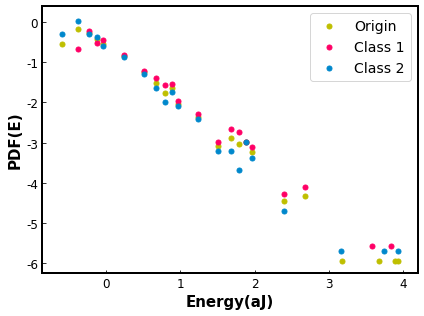

In [43]:
if __name__ == "__main__":
    # SetID, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts, TRAI
    feature_idx = [4, 6, 7]
    interval_num = 6
    interval = 1 / interval_num
    interz = []
    midz = []

    for idx in feature_idx:
        tmp = chan_2[:, idx]
        tmp_max = int(max(tmp))
        tmp_min = int(min(tmp))
        if tmp_min <= 0:
            interz.append([0] + [pow(10, i) for i in range(len(str(tmp_max)))])
            midz.append([interval * pow(10, i)
                         for i in range(len(str(tmp_max)) + 1)])
        else:
            interz.append([pow(10, i) for i in range(len(str(tmp_min)) - 1, 
                                                     len(str(tmp_max)))])
            midz.append([interval * pow(10, i) 
                         for i in range(len(str(tmp_min)), 
                                        len(str(tmp_max)) + 1)])

    xlabelz = ['Amplitude(μV)', 'Duration(μs)', 'Energy(aJ)']
    ylabelz = ['PDF(A)', 'PDF(D)', 'PDF(E)']
    
    fig = plt.figure(figsize=[6, 4.5])

    features_path = '/home/Yuanbincheng/data/electrolysis/Ni-tension test-electrolysis-1-0.01-AE-20201031.txt'
    
#     cal_ML(chan_2[:, 7], features_path, cls_1_KKM, cls_2_KKM, 'Energy(aJ)', r'$\epsilon$')
    cal_PDF(chan_2[:, 7], features_path, interz[2], midz[2], interval_num, cls_1_KKM, cls_2_KKM, 'Energy(aJ)', 'PDF(E)')
#     cal_CCDF(chan_2[:, 7], features_path, cls_1_KKM, cls_2_KKM, 'Energy(aJ)', 'CCD C(s)')
#     cal_contour(chan_2[:, 6], chan_2[:, 7], 'Energy(aJ)', 'Duration(μs)', 'Contour')
#     cal_correlation(Dur, Eny, cls_1_KKM, cls_2_KKM, 'Duration(μs)', 'Energy(aJ)')

### Waveform-Find with TRAI

In [22]:
def cal_wave(i, valid=True):
    # Time, Chan, Thr, SampleRate, Samples, TR_mV, Data, TRAI
    sig = np.multiply(array.array('h', bytes(i[-2])), i[-3] * 1000)
    time = np.linspace(0, pow(i[-5], -1) * (i[-4] - 1) * pow(10, 6), i[-4])
    thr = i[2]
    if valid:
        valid_wave_idx = np.where(abs(sig) >= thr)[0]
        start = time[valid_wave_idx[0]]
        end = time[valid_wave_idx[-1]]
        duration = end - start
        N = valid_wave_idx[-1] + 1 - valid_wave_idx[0]
        sig = sig[valid_wave_idx[0]:(valid_wave_idx[-1] + 1)]
        time = np.linspace(0, duration, sig.shape[0])
    return time, sig

#### 316L

In [33]:
TRAI_1 = [2939, 33400, 3391, 1720, 1882, 12861, 21555, 85898, 65567, 42415]
TRAI_2 = [39553, 22378, 88770, 1808, 102212, 225509, 26146, 55467, 81744, 134964]

#### Ni-electrolysis

In [456]:
# 1.263, 1.395, 1.538, 1.728, 1.832, 2.233, 2.450, 2.573, 2.702, 3.079
idx_1 = [5, 70, 3, 9, 0, 20, 136, 42, 54, 108]
TRAI_1 = [735, 3218, 593, 1138, 323, 2001, 6585, 2614, 2832, 4619]

# 1.365, 1.495, 1.773, 1.839, 1.95, 2.258, 2.390, 2.507, 2.680, 2.875
idx_2 = [0, 172, 1, 3, 5, 112, 7, 144, 2, 137]
TRAI_2 = [323, 9776, 383, 593, 735, 4694, 909, 7445, 405, 6695]

In [20]:
# 0.115, 0.275, 0.297, 0.601, 1.024
idx_select_2 = [50, 148, 51, 252, 10]
TRAI_select_2 = [3067, 11644, 3079, 28583, 1501]

# 0.303, 0.409, 0.534, 0.759, 1.026
idx_select_1 = [13, 75, 79, 72, 71]
TRAI_select_1 = [2949, 14166, 14815, 14140, 14090]

#### Ni-pure

In [471]:
# 1.263, 1.365, 1.422, 1.552, 1.601, 1.749, 1.875, 1.965, 2.339, 2.522
idx_1 = [23, 2, 77, 3, 19 ,0 , 24, 22, 59, 101]
TRAI_1 = [13345, 2751, 63678, 2876, 8716, 425, 13697, 12594, 49370, 81608]

# 1.288, 1.365, 1.413, 1.552, 1.676, 1.785, 1.899, 1.975, 2.149, 2.341
idx_2 = [60, 5, 9, 21, 8, 38, 0, 109, 3, 44]
TRAI_2 = [52208, 3851, 4720, 11113, 4701, 22311, 425, 86575, 2876, 26988]

In [ ]:
data_tra[2938][-1], N_pri, N_tra, data_pri.shape

In [ ]:
# Time, Amp, RiseTime, Dur, Eny, Counts, TRAI
for i in TRAI_2:
    vallen = data_pri[i-1]
    print('{:.8f} {} {} {} {} {:.0f} {:.0f}'.format(vallen[1], vallen[4], vallen[5], vallen[6], vallen[-4], vallen[-2], vallen[-1]))

In [ ]:
for i in TRAI_2:
    validation(i-1)

In [ ]:
# Waveform with specific TRAI
fig = plt.figure(figsize=(6, 3))
j = 1501
i = data_tra[j-1]
time, sig = cal_wave(i, valid=False)

ax = fig.add_subplot(1, 1, 1)
ax.plot(time, sig)
plt.axhline(abs(i[2]), 0, valid_data.shape[0], linewidth=1, color="red")
plt.axhline(-abs(i[2]), 0, valid_data.shape[0], linewidth=1,color="red")
plot_norm(ax, 'Time', 'Signal', title='TRAI:%d'%j, legend=False, grid=True)

In [27]:
# Selected waveform
wave = []
fig = plt.figure(figsize=(12, 15))

for idx, j in enumerate(TRAI_select_1):
    i = data_tra[j-1]
    valid_time, valid_data = cal_wave(i, valid=False)
    wave.append(valid_data)

    ax = fig.add_subplot(5, 2, 1 + idx * 2)
    ax.plot(valid_time, valid_data)
    ax.axhline(abs(i[2]), 0, valid_data.shape[0], linewidth=1, color="red")
    ax.axhline(-abs(i[2]), 0, valid_data.shape[0], linewidth=1, color="red")
    plot_norm(ax, 'Time', 'Signal', title='TRAI:%d'%j, legend=False, grid=True)

    half_frq, normalization_half = cal_frequency(j-1, valid=False)
#     freq.append(normalization_half)

    ax = fig.add_subplot(5, 2, 2 + idx * 2)
    ax.plot(half_frq, normalization_half)
    plot_norm(ax, 'Freq (Hz)', '|Y(freq)|', 'TRAI:%d'%j, x_lim=[0, pow(10, 6)], legend=False)

In [ ]:
# Validate TRAI correct or not
with open('val.txt', 'w') as f:
    for i in tqdm(TRAI_1):
        f.write('%d\n'%data_tra[i-1][-1])

In [474]:
# Save waveform
os.chdir(r'/home/Yuanbincheng/data/pure')
for idx, j in enumerate(tqdm(TRAI_1)):
    i = data_tra[j-1]
    valid_time, valid_data = cal_wave(i)
    with open(path_pri[:-6] + '_pop1-%d'%(idx+1) + '.txt', 'w') as f:
        f.write('Time, Signal\n')
        for k in range(valid_data.shape[0]):
            f.write("{}, {}\n".format(valid_time[k], valid_data[k]))


100%|██████████| 10/10 [00:00<00:00, 147.91it/s]

### Frequency

In [24]:
def cal_frequency(k, valid=True):
    i = data_tra[k]
    sig = np.multiply(array.array('h', bytes(i[-2])), i[-3] * 1000)
    thr, Fs = i[2], i[3]
    Ts = 1 / Fs
    if valid:
        valid_wave_idx = np.where(abs(sig) >= thr)[0]
        sig = sig[valid_wave_idx[0]:(valid_wave_idx[-1] + 1)]
    N = sig.shape[0]
    fft_y = fft(sig)
    abs_y = np.abs(fft_y)
    normalization = abs_y / N
    normalization_half = normalization[range(int(N / 2))]
    frq = (np.arange(N) / N) * Fs
    half_frq = frq[range(int(N / 2))]
    # freq_max.append(half_frq[np.argmax(normalization_half)])
#     print(i[-1], half_frq[np.argmax(normalization_half)])
    return half_frq, normalization_half

33400 415760.8695652174


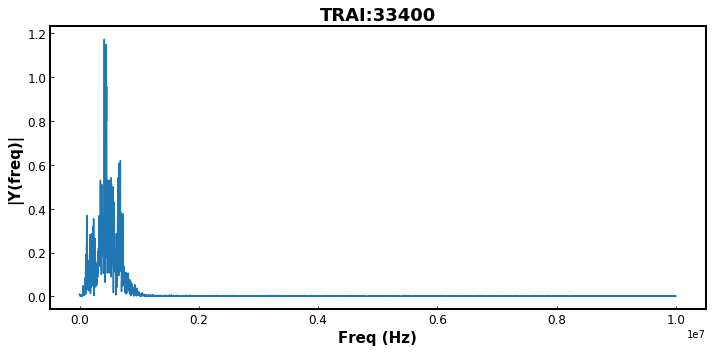

In [18]:
k = 33399
half_frq, normalization_half = cal_frequency(k, valid=False)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(half_frq, normalization_half)
plot_norm(ax, 'Freq (Hz)', '|Y(freq)|', 'TRAI:%d'%(k+1), legend=False)

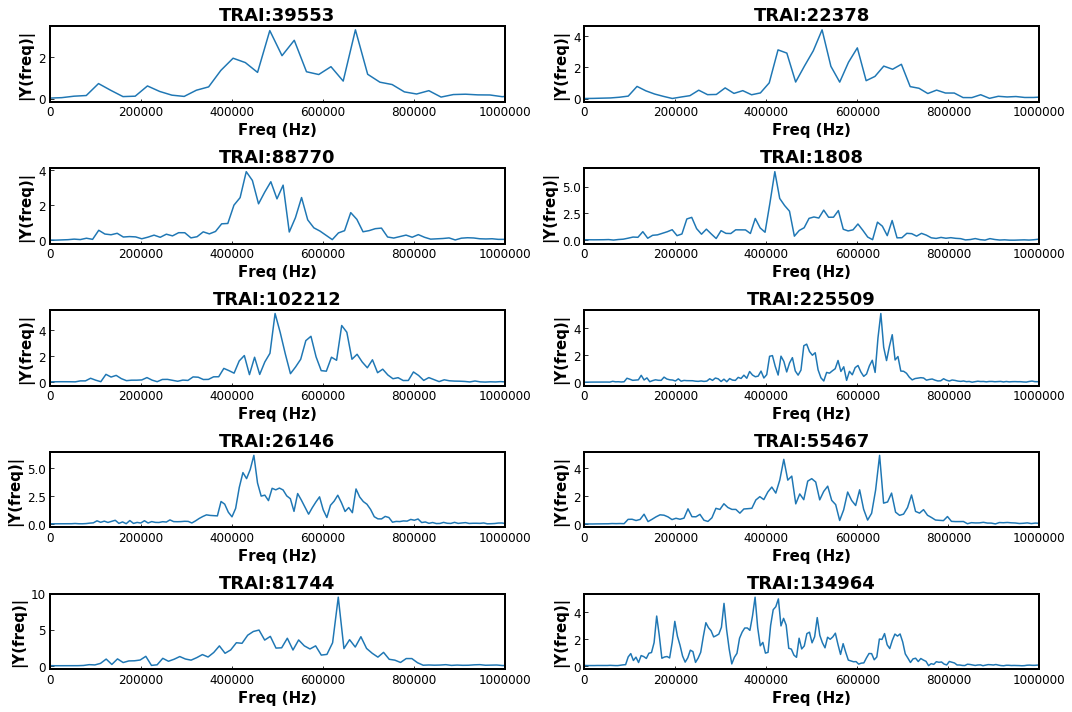

In [37]:
# Selected waveform to transform
freq = []
fig = plt.figure(figsize=(12, 15))

for idx, k in enumerate(TRAI_2):
    half_frq, normalization_half = cal_frequency(k-1)
    freq.append(normalization_half)
    
    ax = fig.add_subplot(5,2,1 + idx)
    ax.plot(half_frq, normalization_half)
    
    plot_norm(ax, 'Freq (Hz)', '|Y(freq)|', 'TRAI:%d'%k, x_lim=[0, pow(10, 6)], legend=False)

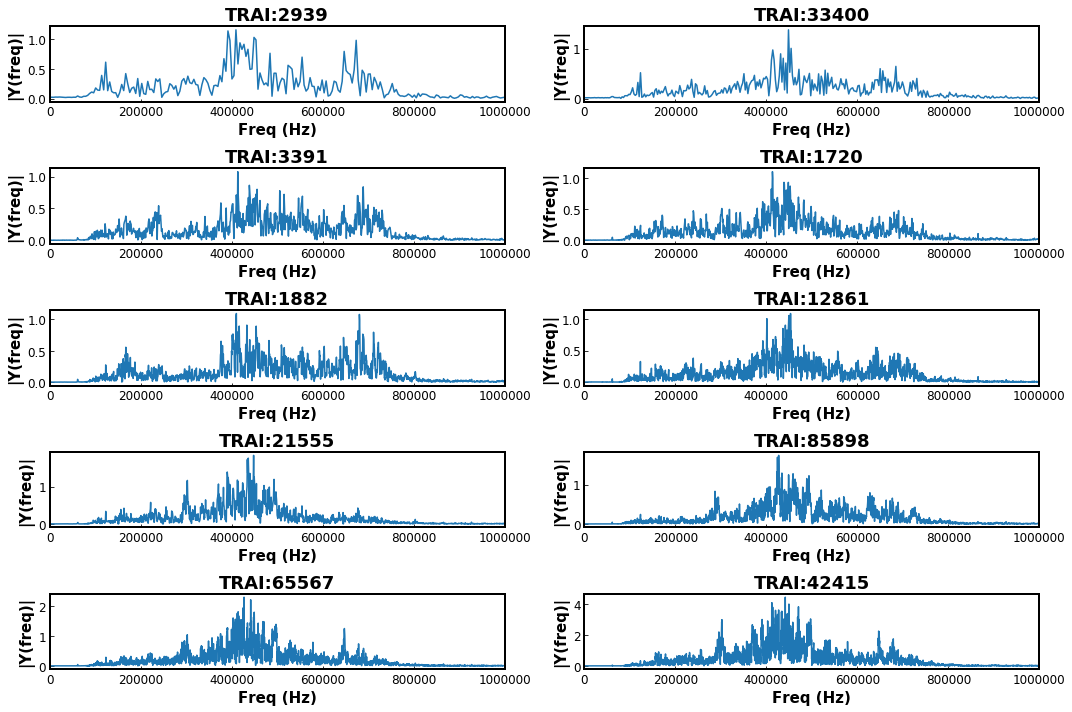

In [38]:
# Selected waveform to transform
freq = []
fig = plt.figure(figsize=(12, 15))

for idx, k in enumerate(TRAI_1):
    half_frq, normalization_half = cal_frequency(k-1)
    freq.append(normalization_half)
    
    ax = fig.add_subplot(5,2,1 + idx)
    ax.plot(half_frq, normalization_half)
    
    plot_norm(ax, 'Freq (Hz)', '|Y(freq)|', 'TRAI:%d'%k, x_lim=[0, pow(10, 6)], legend=False)

### Search

In [ ]:
path = r'D:\Dataset\vallen\Ni-tension test-electrolysis-1-0.01-AE-20201031'

os.chdir(path)
features_path = r'Ni-tension test-electrolysis-1-0.01-AE-20201031.txt'
# Ni-tension test-pure-1-0.01-AE-20201030
# Ni-tension test-electrolysis-1-0.01-AE-20201031

# SetID, TRAI, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts, Frequency(Hz)
with open(features_path, 'r') as f:
    feature = np.array([i.split(',')[2:] for i in f.readlines()[1:]])
feature = feature.astype(np.float32)

### Export data through time selection

In [ ]:
t1 = []
t2 = []
t3 = []

for _ in tqdm(range(N_pri)):
    i = result_pri.fetchone()
    if i[-2] is not None and i[-2] >= 6:
        if 1200 <= i[1] < 1764:
            t1.append(i)
        if 1764 <= i[1] < 2968:
            t2.append(i)
        if 2968 <= i[1] < 5000:
            t3.append(i)

In [ ]:
len(valid_idx), len(t1), len(t2)

In [ ]:
# save features to file
with open(path_pri[-6] + '-2968-5000.txt', 'w') as f:
    f.write('SetID, TRAI, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts\n')
    # ID, Time(s), Chan, Thr(μV), Thr(dB), Amp(μV), Amp(dB), RiseT(s), Dur(s), Eny(aJ), RMS(μV), Counts, Frequency(Hz)
    for i in t3:
        f.write('{}, {}, {:.8f}, {}, {:.7f}, {:.7f}, {:.2f}, {:.2f}, {:.7f}, {:.7f}, {}\n'.format(
            i[0], i[-1], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9]))

### Append frequency

In [ ]:
valid_idx = []
for idx, i in enumerate(result_pri):
    if i[-1] not in [None, 0]:
        valid_idx.append(idx)
valid_pri = np.array(result_pri)[valid_idx]

freq_max = []
result_tra = sorted(result_tra, key=lambda x: x[-1])
for idx, i in enumerate(tqdm(result_tra)):
    sig = np.multiply(array.array('h', bytes(i[-2])), i[-3] * 1000)
    thr = i[2]
    Fs = i[3]
    Ts = 1 / Fs
    if valid_pri[idx][-2] > 1:
        valid_wave_idx = np.where(abs(sig) >= thr)[0]
        valid_data = sig[valid_wave_idx[0]:(valid_wave_idx[-1] + 1)]
        N = valid_data.shape[0]
        fft_y = fft(valid_data)
        abs_y = np.abs(fft_y)
        normalization = abs_y / N
        normalization_half = normalization[range(int(N / 2))]
        frq = (np.arange(N) / N) * Fs
        half_frq = frq[range(int(N / 2))]
        try:
            freq_max.append(half_frq[np.argmax(normalization_half)])
        except:
            freq_max.append(frq[0])

In [ ]:
# save features to file
with open('Ni-tension test-electrolysis-1-0.01-AE-20201031.txt', 'w') as f:
    f.write(
        'SetID, TRAI, Time, Chan, Thr, Amp, RiseT, Dur, Eny, RMS, Counts\n')
    # ID, Time(s), Chan, Thr(μV), Thr(dB), Amp(μV), Amp(dB), RiseT(s), Dur(s), Eny(aJ), RMS(μV), Counts, Frequency(Hz)
    j = 0
    for i in valid_pri:
        if i[-2] > 1:
            f.write('{}, {}, {:.8f}, {}, {:.7f}, {:.7f}, {:.2f}, {:.2f}, {:.7f}, {:.7f}, {}\n'.format(
                i[0], i[-1], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9]))
            j += 1

### Read

In [ ]:
def sqlite_read(path):
    """
    python读取sqlite数据库文件
    """
    mydb = sqlite3.connect(path)                # 链接数据库
    mydb.text_factory = lambda x: str(x, 'gbk', 'ignore')
    cur = mydb.cursor()                         # 创建游标cur来执行SQL语句

    # 获取表名
    cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
    Tables = cur.fetchall()                     # Tables 为元组列表
#     print(Tables)

#     i = 0
#     while True:
#         try:
#             tbl_name = Tables[i][0]                     # 获取第一个表名
#             print(tbl_name)
#         except:
#             break
#         # 获取表的列名
#         cur.execute("SELECT * FROM {}".format(tbl_name))
#         col_name_list = [tuple[0] for tuple in cur.description]
#         pprint.pprint(col_name_list)
#         i += 1

    # 获取表结构的所有信息
    cur.execute("SELECT * FROM {}".format(Tables[3][0]))
    res = cur.fetchall()
#     pprint.pprint(cur.fetchall()[-1][1])
    return int(res[-2][1]), int(res[-1][1])

In [ ]:
sqlite_read(path_pri)

In [ ]:
conn.execute("PRAGMA table_info(view_tr_data)").fetchall()